## RADIOML2018.01A
[deepsig.ai/datasets](https://www.deepsig.ai/datasets)

The dataset is provided in the "GOLDXYZOSC.0001_1024.hdf5" file. The HDF5 format is designed to store and organize large amounts of data.

The dataset exhibits the following structure:
```
    24 modulations: OOK, ASK4, ASK8, BPSK, QPSK, PSK8, PSK16, PSK32, APSK16, APSK32, APSK64, APSK128, QAM16, QAM32, QAM64, QAM128, QAM256, AMSSBWC, AMSSBSC, AMDSBWC, AMDSBSC, FM, GMSK and OQPS.
    26 SNRs per modulation (-20 dB to +30 dB in steps of 2dB).
    4096 frames per modulation-SNR combination.
    1024 complex time-series samples per frame.
    Samples as floating point in-phase and quadrature (I/Q) components, resulting in a (1024,2) frame shape.
    2.555.904 frames in total.
```
Each frame can be retrieved by accessing the HDF5 groups:
```
    X: I/Q components of the frame;
    Y: Modulation of the frame (one-hot encoded)
    Z: SNR of the frame
```
Data consist of 24 Modulations --> 26 SNR --> 4096 Frames --> (1024, 2) I/Q Samples. Below is a structural example of the dataset:

```
Modulation 0: {
    SNR -20: [
            Frame 0:                # sample 0 (e.g. hdf5_file['X'][0])
                [
                    [I0, Q0],       # sample 0.0 (e.g. hdf5_file['X'][0][0])
                    [I1, Q1],       # sample 0.1 (e.g. hdf5_file['X'][0][1])
                    ...,
                    [I1023, Q1023]  # sample 0.1023 (e.g. hdf5_file['X'][0][1023])
                ],
            Frame 1: [ ... ]    # sample 1 (e.g. hdf5_file['X'][1])
            ...,
            Frame 4094: [ ... ] # sample 4094 (e.g. hdf5_file['X'][4094])
            Frame 4095: [ ... ] # sample 4095 (e.g. hdf5_file['X'][4095])
        ]
    SNR -18: [
            Frame 0: [ ... ]    # sample 4096 (e.g. hdf5_file['X'][4096])
            ...,
            Frame 4095: [ ... ] # sample 8191 (e.g. hdf5_file['X'][8191])
        ]
    ...
    SNR 30: [
            Frame 0: [ ... ]    # sample 102400 (e.g. hdf5_file['X'][102400])
            ...,
            Frame 4095: [ ... ] # sample 106495 (e.g. hdf5_file['X'][106495])
        ]
}
...
Modulation 23: {
    ...
}
```

In [140]:
import h5py
import numpy as np
import json


xyz = h5py.File("../data/GOLD_XYZ_OSC.0001_1024.hdf5", "r")
modulation_classes = json.load(open("../data/classes-fixed.json"))

frame = xyz["X"]
modulation_onehot = xyz["Y"]
snr = xyz["Z"]
snrs = set([snr[i][0] for i in range(len(snr))])

assert len(modulation_classes) == modulation_onehot[0].shape[0]
int_to_modulation = {i: modulation for i, modulation in enumerate(modulation_classes)}


def onehot_to_int(onehot):
    return np.argmax(onehot)


int_to_modulation


{0: 'OOK',
 1: '4ASK',
 2: '8ASK',
 3: 'BPSK',
 4: 'QPSK',
 5: '8PSK',
 6: '16PSK',
 7: '32PSK',
 8: '16APSK',
 9: '32APSK',
 10: '64APSK',
 11: '128APSK',
 12: '16QAM',
 13: '32QAM',
 14: '64QAM',
 15: '128QAM',
 16: '256QAM',
 17: 'AM-SSB-WC',
 18: 'AM-SSB-SC',
 19: 'AM-DSB-WC',
 20: 'AM-DSB-SC',
 21: 'FM',
 22: 'GMSK',
 23: 'OQPSK'}

In [141]:
snrs, len(snrs)

({-20,
  -18,
  -16,
  -14,
  -12,
  -10,
  -8,
  -6,
  -4,
  -2,
  0,
  2,
  4,
  6,
  8,
  10,
  12,
  14,
  16,
  18,
  20,
  22,
  24,
  26,
  28,
  30},
 26)

In [142]:
idx = 0
modulation_str = int_to_modulation[onehot_to_int(modulation_onehot[idx])]
print(
    frame,
    f"Frame: {idx}\n"
    f"\t- Modulation: {modulation_str}\n"
    f"\t- SNR: {snr[idx]}\n"
    f"\t- Samples: {frame[idx].shape}"
)


<HDF5 dataset "X": shape (2555904, 1024, 2), type "<f4"> Frame: 0
	- Modulation: OOK
	- SNR: [-20]
	- Samples: (1024, 2)


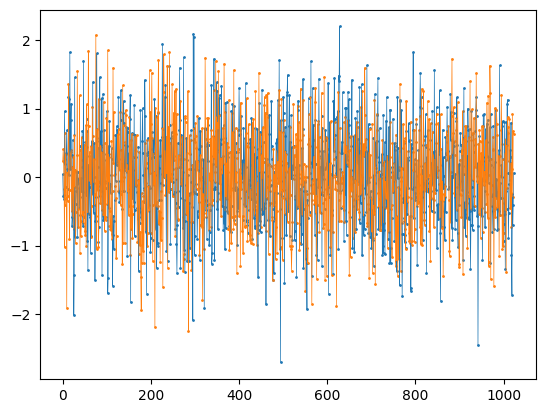

In [143]:
from matplotlib import pyplot as plt


plt.scatter([i for i in range(1024)], frame[idx][:, 0], s=1)
plt.scatter([i for i in range(1024)], frame[idx][:, 1], s=1)
plt.plot(frame[idx], linewidth=0.5)

In [144]:
import torch


class RADIOML201801A(torch.utils.data.Dataset):
    def __init__(self, path, modulation_classes, transform=None):
        self.path = path
        self.modulation_classes = modulation_classes
        self.transform = transform

        self.xyz = h5py.File(self.path, "r")
        self.frame = self.xyz["X"]
        self.modulation_onehot = self.xyz["Y"]
        self.snr = self.xyz["Z"]

    def __len__(self):
        return len(self.frame)

    def __getitem__(self, idx):
        frame = self.frame[idx]
        modulation_onehot = self.modulation_onehot[idx]
        snr = self.snr[idx]

        if self.transform:
            frame = self.transform(frame)

        return frame, modulation_onehot, snr

dataset = RADIOML201801A("../data/GOLD_XYZ_OSC.0001_1024.hdf5", modulation_classes)

In [145]:
# for each of 24 modulations
#   for each of 26 SNRs
#     sample X% random indices of 4096 samples for training, the rest for validation
# Modulation 0: {
#     SNR -20: [
#             Frame 0:  
import random
from typing import Tuple


def random_split_list(l, n):
    l = set(l)
    sample = set(random.sample(list(l), n))
    return list(sample), list(l - sample)


def get_train_val_indices(num_blocks: int, block_size: int, num_val_per_block: int) -> Tuple[list, list]:
    """Iterate through num_blocks * block_size indices in consecutive block_size chunks. For each block,
    select num_val_per_block indices for validation and the rest for training.

    Args:
        num_blocks (int): Total number of blocks to iterate through.
        block_size (int): Size of each block.
        num_val_per_block (int): Number of indices to select for validation in each block.

    Returns:
        Tuple[list, list]: Training and validation indices.
    """
    training_set_indices = []
    validation_set_indices = []
    for i in range(num_blocks):
        val_indices, train_indices = random_split_list(list(range(block_size)), num_val_per_block)
        training_set_indices += list(np.array(train_indices) + i*block_size)
        validation_set_indices += list(np.array(val_indices) + i*block_size)
    
    assert len(set(training_set_indices)) + len(set(validation_set_indices)) == num_blocks*block_size

    return training_set_indices, validation_set_indices


num_modulations = 24
num_snrs = 26
num_blocks = num_modulations*num_snrs
block_size = 4096
num_val_per_block = int(.1*block_size)
training_set_indices, validation_set_indices = get_train_val_indices(num_blocks, block_size, num_val_per_block)

In [146]:
from torch.utils.data import Subset
from torch.utils.data import DataLoader


batch_size = 4
training_set = Subset(dataset, training_set_indices)
validation_set = Subset(dataset, validation_set_indices)
training_dataloader = DataLoader(training_set, batch_size=batch_size, shuffle=True)
validation_dataloader = DataLoader(validation_set, batch_size=batch_size, shuffle=True)

In [147]:
x = next(iter(training_dataloader))
x[0].shape, x[1].shape, x[2].shape

(torch.Size([4, 1024, 2]), torch.Size([4, 24]), torch.Size([4, 1]))